Imports

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from patsy import dmatrices
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore", category=ConvergenceWarning)

Load data

In [3]:
df = pd.read_csv("Credit.csv")
df = df.drop('Unnamed: 0', axis=1)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     400 non-null    float64
 1   Limit      400 non-null    int64  
 2   Rating     400 non-null    int64  
 3   Cards      400 non-null    int64  
 4   Age        400 non-null    int64  
 5   Education  400 non-null    int64  
 6   Gender     400 non-null    object 
 7   Student    400 non-null    object 
 8   Married    400 non-null    object 
 9   Ethnicity  400 non-null    object 
 10  Balance    400 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 34.5+ KB
None


,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


Decision tree classifier

In [4]:
def decisionTree(df, formula, seed, max_depth=3):
    np.random.seed(seed)
    mask = np.random.rand(len(df)) < 0.8
    train_set = df[mask]
    valid_set = df[~mask]
    
    train_y, train_x = dmatrices(formula, data=train_set, return_type="dataframe")
    valid_y, valid_x = dmatrices(formula, data=valid_set, return_type="dataframe")
    
    model = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    model.fit(train_x, train_y)
    
    train_acc = accuracy_score(train_y, model.predict(train_x))
    val_acc = accuracy_score(valid_y, model.predict(valid_x))
    val_maj_proportion = max(valid_set[formula.split()[0]].value_counts(normalize=True))

    return train_acc, val_acc, val_maj_proportion

KNN classifier

In [5]:
def knn(df, formula, seed, n_neighbors=5):
    np.random.seed(seed)
    mask = np.random.rand(len(df)) < 0.8
    train_set = df[mask]
    valid_set = df[~mask]
    
    train_y, train_x = dmatrices(formula, data=train_set, return_type="dataframe")
    valid_y, valid_x = dmatrices(formula, data=valid_set, return_type="dataframe")
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    train_y = np.array(train_y).reshape(len(train_y,))
    model.fit(train_x, train_y)
    
    train_acc = accuracy_score(train_y, model.predict(train_x))
    val_acc = accuracy_score(valid_y, model.predict(valid_x))
    val_maj_proportion = max(valid_set[formula.split()[0]].value_counts(normalize=True))

    return train_acc, val_acc, val_maj_proportion

Predict

In [6]:
df_numeric = pd.get_dummies(df, columns=["Gender", "Student", "Married", "Ethnicity"], drop_first=True)
correlation_matrix = df_numeric.corr()
print("Cards:")
print(correlation_matrix["Cards"].drop("Cards").sort_values(ascending=False))

Cards:
Balance                0.086456
Rating                 0.053239
Age                    0.042948
Limit                  0.010231
Ethnicity_Asian        0.005591
Ethnicity_Caucasian   -0.005631
Married_Yes           -0.009695
Income                -0.018273
Gender_Female         -0.022658
Student_Yes           -0.026164
Education             -0.051084
Name: Cards, dtype: float64


Decision Tree

In [7]:
formulas = [
    "Cards ~ Income",
    "Cards ~ Limit",
    "Cards ~ Rating",
    "Cards ~ Age",
    "Cards ~ Education",
    "Cards ~ Gender",
    "Cards ~ Student",
    "Cards ~ Married",
    "Cards ~ Ethnicity",
    "Cards ~ Balance",
]
better_formulas = [
    "Cards ~ Balance + Rating",
    "Cards ~ Balance + Rating + Education",
    "Cards ~ Balance + Rating + Age",
    "Cards ~ Balance + Rating + Education + Age",
    "Cards ~ Balance + Rating + Education + Age + Limit",
    "Cards ~ Balance + Rating + Education + Age + Limit + Income",
    "Cards ~ Balance + Rating + Education + Age + Limit + Income + Student",
    "Cards ~ Balance + Rating + Education + Age + Limit + Income + Student + Gender",
]

seed = np.random.randint(2**32)
train_acc, val_acc, val_maj_proportion = decisionTree(df, "Cards ~ Limit", seed)
print(f"\033[91mMajority class proportion of validation set: {val_maj_proportion:.4f}\033[0m")
for f in formulas:
    print(f"\033[94m{f}:\033[0m")
    train_acc, val_acc, _ = decisionTree(df, f, seed, 3)
    print(f"\tValidation accuracy: {val_acc:.4f}")
print("--------------------------------------")
for f in better_formulas:
    print(f"\033[94m{f}:\033[0m")
    train_acc, val_acc, _ = decisionTree(df, f, seed, 3)
    print(f"\tTraining accuracy: {train_acc:.4f}")
    print(f"\tValidation accuracy: {val_acc:.4f}")

Majority class proportion of validation set: 0.2410
Cards ~ Income:
	Validation accuracy: 0.1687
Cards ~ Limit:
	Validation accuracy: 0.1928
Cards ~ Rating:
	Validation accuracy: 0.2651
Cards ~ Age:
	Validation accuracy: 0.2651
Cards ~ Education:
	Validation accuracy: 0.1928
Cards ~ Gender:
	Validation accuracy: 0.2410
Cards ~ Student:
	Validation accuracy: 0.1928
Cards ~ Married:
	Validation accuracy: 0.2410
Cards ~ Ethnicity:
	Validation accuracy: 0.2169
Cards ~ Balance:
	Validation accuracy: 0.2410
--------------------------------------
Cards ~ Balance + Rating:
	Training accuracy: 0.3565
	Validation accuracy: 0.2530
Cards ~ Balance + Rating + Education:
	Training accuracy: 0.3691
	Validation accuracy: 0.2410
Cards ~ Balance + Rating + Age:


	Training accuracy: 0.3565
	Validation accuracy: 0.2530
Cards ~ Balance + Rating + Education + Age:
	Training accuracy: 0.3691
	Validation accuracy: 0.2410
Cards ~ Balance + Rating + Education + Age + Limit:
	Training accuracy: 0.3628
	Validation accuracy: 0.2410
Cards ~ Balance + Rating + Education + Age + Limit + Income:
	Training accuracy: 0.3502
	Validation accuracy: 0.2530
Cards ~ Balance + Rating + Education + Age + Limit + Income + Student:
	Training accuracy: 0.3502
	Validation accuracy: 0.2530
Cards ~ Balance + Rating + Education + Age + Limit + Income + Student + Gender:
	Training accuracy: 0.3502
	Validation accuracy: 0.2530


KNN

In [8]:
formulas = [
    "Cards ~ Income",
    "Cards ~ Limit",
    "Cards ~ Rating",
    "Cards ~ Age",
    "Cards ~ Education",
    "Cards ~ Gender",
    "Cards ~ Student",
    "Cards ~ Married",
    "Cards ~ Ethnicity",
    "Cards ~ Balance",
]
better_formulas = [
    "Cards ~ Balance + Rating",
    "Cards ~ Balance + Rating + Education",
    "Cards ~ Balance + Rating + Age",
    "Cards ~ Balance + Rating + Education + Age",
    "Cards ~ Balance + Rating + Education + Age + Limit",
    "Cards ~ Balance + Rating + Education + Age + Limit + Income",
    "Cards ~ Balance + Rating + Education + Age + Limit + Income + Student",
    "Cards ~ Balance + Rating + Education + Age + Limit + Income + Student + Gender",
]

seed = np.random.randint(2**32)
train_acc, val_acc, val_maj_proportion = knn(df, "Cards ~ Limit", seed)
print(f"\033[91mMajority class proportion of validation set: {val_maj_proportion:.4f}\033[0m")
for f in formulas:
    print(f"\033[94m{f}:\033[0m")
    train_acc, val_acc, _ = knn(df, f, seed, 5)
    print(f"\tValidation accuracy: {val_acc:.4f}")
print("--------------------------------------")
for f in better_formulas:
    print(f"\033[94m{f}:\033[0m")
    train_acc, val_acc, _ = knn(df, f, seed, 5)
    print(f"\tTraining accuracy: {train_acc:.4f}")
    print(f"\tValidation accuracy: {val_acc:.4f}")

Majority class proportion of validation set: 0.3171
Cards ~ Income:
	Validation accuracy: 0.1951
Cards ~ Limit:
	Validation accuracy: 0.2073
Cards ~ Rating:
	Validation accuracy: 0.2317
Cards ~ Age:
	Validation accuracy: 0.2683
Cards ~ Education:
	Validation accuracy: 0.1951
Cards ~ Gender:
	Validation accuracy: 0.3049
Cards ~ Student:
	Validation accuracy: 0.3049
Cards ~ Married:
	Validation accuracy: 0.3293
Cards ~ Ethnicity:
	Validation accuracy: 0.2561
Cards ~ Balance:
	Validation accuracy: 0.2683
--------------------------------------
Cards ~ Balance + Rating:
	Training accuracy: 0.4843
	Validation accuracy: 0.2317
Cards ~ Balance + Rating + Education:
	Training accuracy: 0.4874
	Validation accuracy: 0.2195
Cards ~ Balance + Rating + Age:
	Training accuracy: 0.5440
	Validation accuracy: 0.2805
Cards ~ Balance + Rating + Education + Age:
	Training accuracy: 0.5346
	Validation accuracy: 0.2805
Cards ~ Balance + Rating + Education + Age + Limit:
	Training accuracy: 0.4811
	Validation

Cross validation and grid search

In [9]:
model_formula = "Cards ~ Balance + Rating + Education + Age"
y, x = dmatrices(model_formula, data=df, return_type='dataframe')
Y = y.values.ravel()
X = x.values

In [10]:
params_opt = {"max_depth": range(1, 50, 1)}

gridSearchCV = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=params_opt, cv=10)
gridSearchCV.fit(X, Y)

results = pd.DataFrame(gridSearchCV.cv_results_)

# Sort the results by the mean test score in descending order
sorted_results = results.sort_values(by="mean_test_score", ascending=False)

# Print the top 5 parameter sets
print("Top 10 parameter sets:")
print(sorted_results.loc[:, ["params", "mean_test_score"]].head(10))

/home/pzalewsk/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Top 10 parameter sets:
              params  mean_test_score
0   {'max_depth': 1}           0.2700
4   {'max_depth': 5}           0.2650
5   {'max_depth': 6}           0.2575
6   {'max_depth': 7}           0.2575
1   {'max_depth': 2}           0.2550
3   {'max_depth': 4}           0.2525
7   {'max_depth': 8}           0.2350
8   {'max_depth': 9}           0.2325
2   {'max_depth': 3}           0.2250
9  {'max_depth': 10}           0.2250


In [11]:
params_opt = {"n_neighbors": range(1, 30, 1)}

gridSearchCV = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params_opt, cv=10)
gridSearchCV.fit(X, Y)

results = pd.DataFrame(gridSearchCV.cv_results_)

# Sort the results by the mean test score in descending order
sorted_results = results.sort_values(by="mean_test_score", ascending=False)

# Print the top 5 parameter sets
print("Top 10 parameter sets:")
print(sorted_results.loc[:, ["params", "mean_test_score"]].head(10))

/home/pzalewsk/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Top 10 parameter sets:
                 params  mean_test_score
10  {'n_neighbors': 11}           0.3250
11  {'n_neighbors': 12}           0.3175
9   {'n_neighbors': 10}           0.3150
1    {'n_neighbors': 2}           0.3150
19  {'n_neighbors': 20}           0.3050
12  {'n_neighbors': 13}           0.3050
17  {'n_neighbors': 18}           0.3050
23  {'n_neighbors': 24}           0.3025
15  {'n_neighbors': 16}           0.3025
24  {'n_neighbors': 25}           0.3025


LRE :
	mean: 0.2375,	std: 0.0000
KNN2:
	mean: 0.3100,	std: 0.0200
KNN10:
	mean: 0.2950,	std: 0.0281
KNN15:
	mean: 0.3000,	std: 0.0285
DTC1:
	mean: 0.2350,	std: 0.0300
DTC5:
	mean: 0.2575,	std: 0.0557
DTC7:
	mean: 0.2125,	std: 0.0627


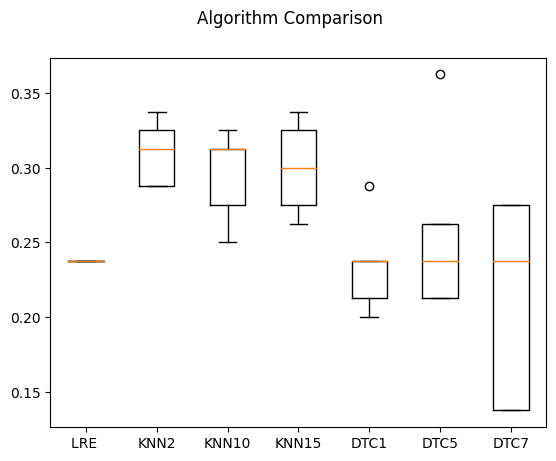

In [12]:
models = []
models.append(('LRE ', LogisticRegression()))
models.append(('KNN2', KNeighborsClassifier(n_neighbors=2)))
models.append(('KNN10', KNeighborsClassifier(n_neighbors=10)))
models.append(('KNN15', KNeighborsClassifier(n_neighbors=15)))
models.append(('DTC1', DecisionTreeClassifier(max_depth=1)))
models.append(('DTC5', DecisionTreeClassifier(max_depth=5)))
models.append(('DTC7', DecisionTreeClassifier(max_depth=7)))

results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=5)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    # msg = "%s:     mean: %f       std: %f" % (name, cv_results.mean(), cv_results.std())
    # print(msg)
    print(f"\033[94m{name}\033[0m:\n\tmean: {cv_results.mean():.4f},\tstd: {cv_results.std():.4f}")

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Decision boundaries

In [13]:
df_numeric = pd.get_dummies(df, columns=["Gender", "Student", "Married", "Ethnicity"], drop_first=True)
correlation_matrix = df_numeric.corr()
print("Cards:")
print(correlation_matrix["Cards"].drop("Cards").sort_values(ascending=False))

Cards:
Balance                0.086456
Rating                 0.053239
Age                    0.042948
Limit                  0.010231
Ethnicity_Asian        0.005591
Ethnicity_Caucasian   -0.005631
Married_Yes           -0.009695
Income                -0.018273
Gender_Female         -0.022658
Student_Yes           -0.026164
Education             -0.051084
Name: Cards, dtype: float64


In [15]:
model_formula = "Cards ~ Balance + Rating"
y, x = dmatrices(model_formula, data=df, return_type='dataframe')
Y = y.values.ravel()
X = x.values[:, 1:3]

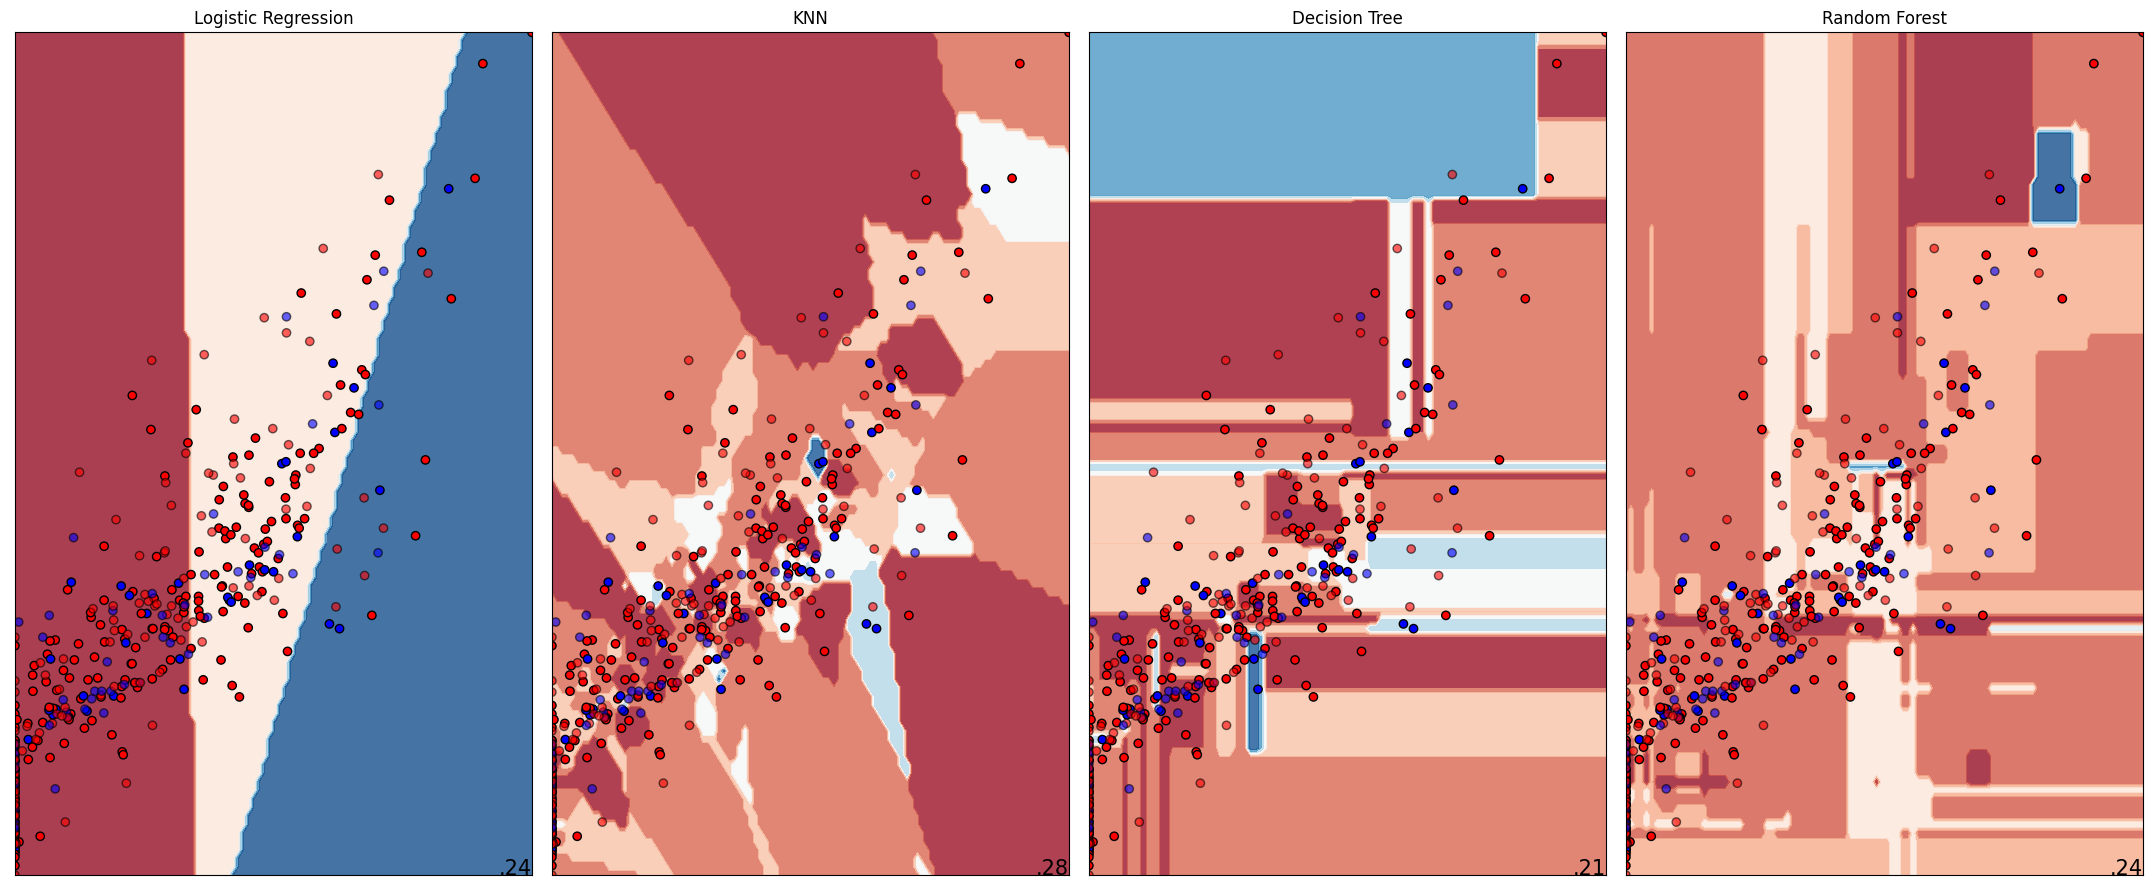

In [16]:
# Define classifiers
names = ["Logistic Regression", "KNN", "Decision Tree", "Random Forest"]
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(2),
    DecisionTreeClassifier(max_depth=11),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
]

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

# Setup plot
figure = plt.figure(figsize=(27, 9))
i = 1
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

# Iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)
    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary
    DecisionBoundaryDisplay.from_estimator(
        clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
    )

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')

    ax.set_xlim(X[:, 0].min(), X[:, 0].max())
    ax.set_ylim(X[:, 1].min(), X[:, 1].max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(X[:, 0].max() - 0.3, X[:, 1].min() + 0.3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i += 1

plt.tight_layout()
plt.show()